In [ ]:
%pip install tensorflow numpy matplotlib scikit-learn pandas

In [ ]:
%pip uninstall tensorflow

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image as imageTf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models
from keras import Sequential, layers
from tensorflow.keras.optimizers import AdamW
from keras.applications import VGG16
from tensorflow.keras.layers import Dense, LeakyReLU
from keras.regularizers import l2
from keras.optimizers import Adam
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [11]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [12]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [4]:
train_dir = 'data/train'
val_dir = 'data/valid'
test_dir = 'data/test'

image_size = 224
batch_size = 32
epoch = 15

In [5]:
train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

val_dataset = image_dataset_from_directory(
    val_dir,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

Found 3570 files belonging to 5 classes.
Found 428 files belonging to 5 classes.
Found 204 files belonging to 5 classes.


In [6]:
# normalization_layer = tf.keras.layers.Rescaling(1./255)
# train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
# val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
# test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

train_dataset = train_dataset.map(lambda x, y: (x, y))
val_dataset = val_dataset.map(lambda x, y: (x, y))
test_dataset = test_dataset.map(lambda x, y: (x, y))


In [7]:
class_names = os.listdir(train_dir)

class_names = [name for name in class_names if os.path.isdir(os.path.join(train_dir, name))]

class_names.sort()

print(class_names)

['Black Soil', 'Cinder Soil', 'Laterite Soil', 'Peat Soil', 'Yellow Soil']


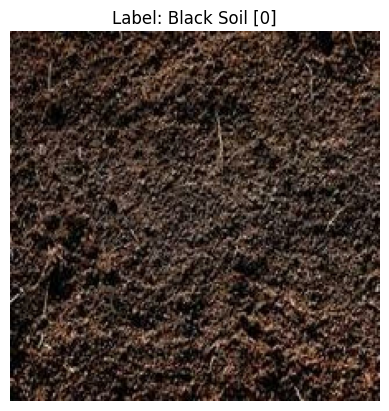

Label: 0 -> Class Name: Black Soil


In [43]:
for images, labels in train_dataset.take(1):
    image = images[0].numpy()
    label = labels[0].numpy()

    class_name = class_names[label]

    # Plot the image
    plt.imshow(image.astype("uint8"))
    plt.title(f"Label: {class_name} [{label}]")
    plt.axis('off')
    plt.show()

    print(f"Label: {label} -> Class Name: {class_name}")

In [44]:
# vgg16_base = VGG16(
#     include_top=False,  # Exclude the default classifier head
#     weights="imagenet",  # Use ImageNet weights
#     input_shape=(image_size, image_size, 3),  # Input shape
#     pooling="avg"  # Global average pooling for feature extraction
# )

# # Freeze the pre-trained base to retain its weights during training
# vgg16_base.trainable = False

In [45]:
model = Sequential([
    layers.Input(shape=(image_size, image_size, 3)),

    layers.Conv2D(64, (3, 3), activation='elu', kernel_regularizer=l2(0.01)),
    layers.BatchNormalization(),  # Add BatchNorm
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(32, (3, 3), activation='elu', kernel_regularizer=l2(0.01)),
    layers.BatchNormalization(),  # Add BatchNorm
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(16, (3, 3), activation='elu', kernel_regularizer=l2(0.01)),
    layers.BatchNormalization(),  # Add BatchNorm
    layers.MaxPooling2D(2, 2),
    
    # layers.GlobalAveragePooling2D(),

    layers.Flatten(),
    
    layers.Dense(128, activation='elu', kernel_regularizer=l2(0.01)),
    layers.Dropout(0.2),
    layers.BatchNormalization(),  # Add BatchNorm
    
    layers.Dense(5, activation='softmax')
])

optimizer = Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [46]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 222, 222, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 109, 109, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 52, 52, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,384,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,411,061 (5.38 MB)

 Trainable params: 1,410,581 (5.38 MB)

 Non-trainable params: 480 (1.88 KB)

In [47]:
def scheduler(epoch, lr):
    if epoch < 3:
        return lr * 1.1
    elif epoch % 10 == 0:
        return lr * 0.5
    return lr

In [48]:
# lr_scheduler = ReduceLROnPlateau(
#     monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6
# )

In [49]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [50]:
history = model.fit(
    train_dataset, 
    epochs=epoch, 
    validation_data=val_dataset, 
    callbacks=[lr_scheduler]
)

Epoch 1/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.7183 - loss: 3.9888 - val_accuracy: 0.7664 - val_loss: 3.8404 - learning_rate: 1.1000e-04
Epoch 2/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9184 - loss: 3.2295 - val_accuracy: 0.9369 - val_loss: 2.9869 - learning_rate: 1.2100e-04
Epoch 3/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9574 - loss: 2.8523 - val_accuracy: 0.9439 - val_loss: 2.6464 - learning_rate: 1.3310e-04
Epoch 4/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9832 - loss: 2.4925 - val_accuracy: 0.9509 - val_loss: 2.3688 - learning_rate: 1.3310e-04
Epoch 5/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9913 - loss: 2.1865 - val_accuracy: 0.9439 - val_loss: 2.0922 - learning_rate: 1.3310e-04
Epoch 6/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9968 - loss: 1.9188 - val_accuracy: 0.9673 - val_loss: 1.8234 - learning_rate: 1.3310e-04
Epoch 7/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - ac

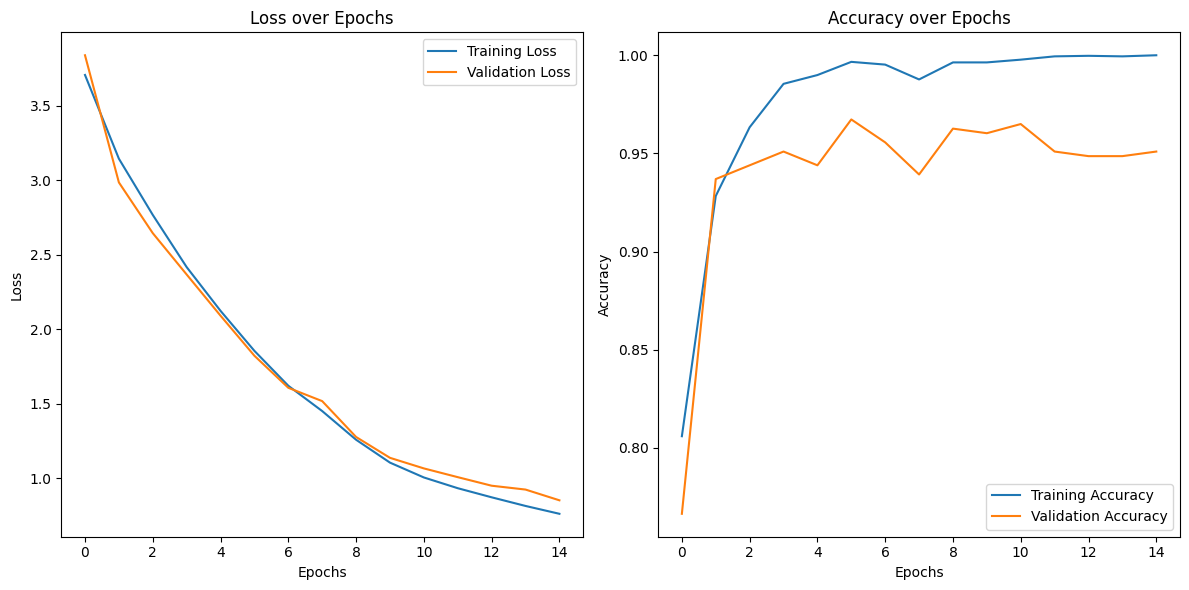

In [51]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [52]:
# import keras


# keras.saving.save_model(model, 'my_model.keras')


In [53]:
# model = tf.keras.models.load_model('my_model.keras')

In [54]:
img_path = 'test/cinder.jpg'

img = imageTf.load_img(img_path, target_size=(224, 224))

img_array = imageTf.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

In [55]:
predictions = model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


In [56]:
predicted_class = np.argmax(predictions, axis=-1)

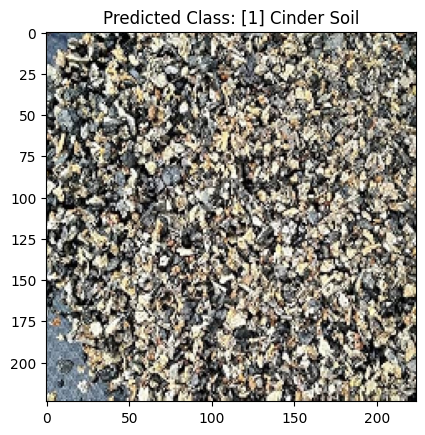

In [57]:
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class} {class_names[predicted_class[0]]}')
plt.show()

In [ ]:
# save modal
model.save("model.h5")
model.save("saved_model/my_model")

In [ ]:
# load model
# from tensorflow.keras.models import load_model

# model = load_model("model.h5")